# **# MBERT ON RANDOM_INSERTION_DELETION**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import torch
from torch.utils.data import Dataset, DataLoader

# Load augmented dataset
file_path = "/content/augmented_random_insertion_deletion.csv"
data = pd.read_csv(file_path)

data['corrected_tweet'] = data['corrected_tweet'].astype(str)


# Split dataset
train_data, temp_data = train_test_split(data, test_size=0.3, stratify=data['class'], random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data['class'], random_state=42)

# Tokenize data
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def tokenize_data(data):
    return tokenizer(
        data['corrected_tweet'].tolist(),  # Use 'tweet' column for tokenization
        padding='max_length',
        truncation=True,
        max_length=64,
        return_tensors='pt'
    )


train_encodings = tokenize_data(train_data)
val_encodings = tokenize_data(val_data)
test_encodings = tokenize_data(test_data)

# Dataset class
class HateSpeechDataset(Dataset):
    def __init__(self, tokenized_texts, labels):
        self.tokenized_texts = tokenized_texts
        self.labels = labels.values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.tokenized_texts['input_ids'][idx],
            'attention_mask': self.tokenized_texts['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = HateSpeechDataset(train_encodings, train_data['class'])
val_dataset = HateSpeechDataset(val_encodings, val_data['class'])
test_dataset = HateSpeechDataset(test_encodings, test_data['class'])

/usr/local/lib/python3.10/dist-packages/transformers/models/bert/tokenization_bert.py:397: RuntimeWarning: coroutine 'Translator.translate' was never awaited
  return ["".join(x) for x in output]
/usr/local/lib/python3.10/dist-packages/transformers/models/bert/tokenization_bert.py:397: RuntimeWarning: coroutine 'run_augmentation' was never awaited
  return ["".join(x) for x in output]
/usr/local/lib/python3.10/dist-packages/transformers/models/bert/tokenization_bert.py:397: RuntimeWarning: coroutine 'batch_back_translate' was never awaited
  return ["".join(x) for x in output]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-33-43cba40218b8>:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/5


  0%|          | 0/2169 [00:00<?, ?it/s]<ipython-input-33-43cba40218b8>:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 2169/2169 [04:17<00:00,  8.43it/s]


Epoch 1 Loss: 0.3271
Epoch 2/5


100%|██████████| 2169/2169 [03:59<00:00,  9.07it/s]


Epoch 2 Loss: 0.2521
Epoch 3/5


100%|██████████| 2169/2169 [03:59<00:00,  9.05it/s]


Epoch 3 Loss: 0.1979
Epoch 4/5


100%|██████████| 2169/2169 [03:58<00:00,  9.10it/s]


Epoch 4 Loss: 0.1456
Epoch 5/5


100%|██████████| 2169/2169 [03:58<00:00,  9.08it/s]


Epoch 5 Loss: 0.1035
Test Metrics:
              precision    recall  f1-score   support

 Hate Speech       0.60      0.63      0.61       429
   Offensive       0.96      0.95      0.96      5757
     Neutral       0.87      0.91      0.89      1249

    accuracy                           0.93      7435
   macro avg       0.81      0.83      0.82      7435
weighted avg       0.93      0.93      0.93      7435



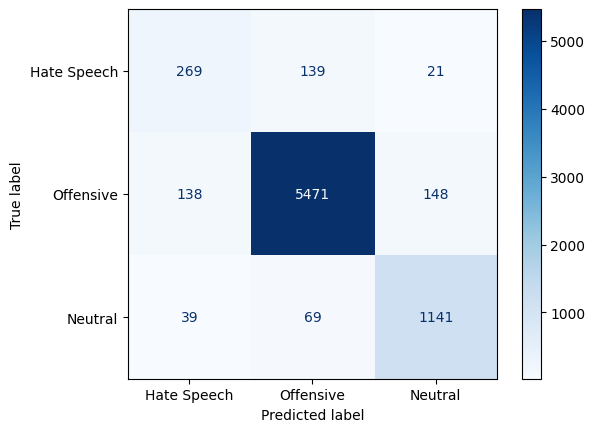

In [ ]:
from transformers import BertForSequenceClassification, AdamW
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

# Load model
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Prepare DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)

# Optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Mixed precision training
scaler = GradScaler()
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss = 0
    print(f"Epoch {epoch + 1}/{epochs}")

    for batch in tqdm(train_dataloader):
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            scaler.scale(loss).backward()

        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()

    print(f"Epoch {epoch + 1} Loss: {total_loss / len(train_dataloader):.4f}")

# Evaluate on Test Set
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_dataloader:
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)

        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, axis=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Test Metrics:")
print(classification_report(all_labels, all_preds, target_names=['Hate Speech', 'Offensive', 'Neutral']))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Hate Speech', 'Offensive', 'Neutral'])
disp.plot(cmap=plt.cm.Blues)
plt.show()
